In [216]:
import numpy as np
import matplotlib.pyplot as plt


In [217]:

class PIDController:
    def __init__(self, Kp, Ki, Kd, output_limits=(None, None)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0
        self.output_min, self.output_max = output_limits
        
    def compute(self, setpoint, pv, dt):
        error = setpoint - pv
        
        # Anti-windup protection
        if self.output_min is not None and self.output_max is not None:
            if (self.integral > 0 and error < 0) or (self.integral < 0 and error > 0):
                self.integral += error * dt
        
        # PID terms
        P = self.Kp * error
        I = self.Ki * self.integral
        D = self.Kd * (error - self.prev_error) / dt
        
        output = P + I + D
        self.prev_error = error
        
        # Output clamping
        if self.output_min is not None and self.output_max is not None:
            output = np.clip(output, self.output_min, self.output_max)
        
        return output


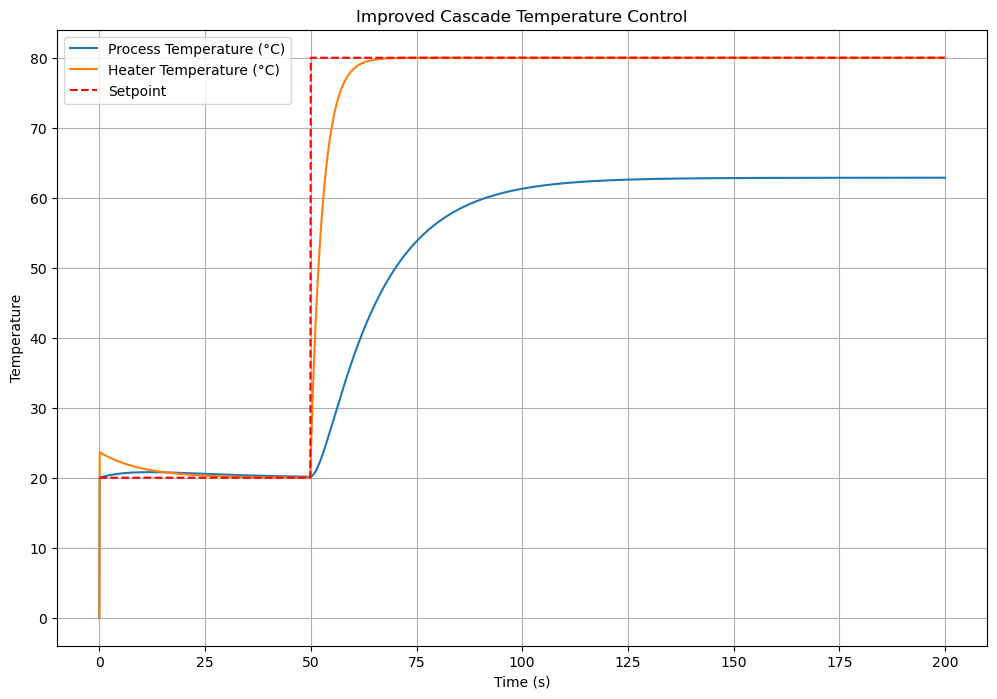

In [218]:

class HeatingSystem:
    def __init__(self):
        self.process_temp = 20.0
        self.heater_temp = 20.0
        self.heat_loss_coeff = 0.02
        self.heater_response_coeff = 0.1
    
    def update(self, power, ambient_temp, dt):
        # Heater dynamics (inner loop process)
        self.heater_temp += (power * 10 - (self.heater_temp - ambient_temp)) * self.heater_response_coeff * dt
        
        # Process dynamics (outer loop process)
        heat_transfer = (self.heater_temp - self.process_temp) * 0.05
        heat_loss = (self.process_temp - ambient_temp) * self.heat_loss_coeff
        self.process_temp += (heat_transfer - heat_loss) * dt
        
        return self.process_temp, self.heater_temp

# Simulation parameters
dt = 0.1
total_time = 200
time = np.arange(0, total_time, dt)

# Controllers
inner_pid = PIDController(Kp=0.25, Ki=0.04, Kd=0.01, output_limits=(0, 100))  # Heater control
outer_pid = PIDController(Kp=9.00, Ki=0.01, Kd=0.03, output_limits=(0, 104))     # Process control

# Simulation
system = HeatingSystem()
setpoint = np.where(time < 50, 20, 80)  # Step change at t=50s
ambient_temp = 20

process_temp = np.zeros_like(time)
heater_temp = np.zeros_like(time)

for i in range(1, len(time)):
    # Outer loop
    heater_setpoint = outer_pid.compute(setpoint[i], process_temp[i-1], dt)
    # heater_setpoint = 20 #manual mode for inner loop training
    # Inner loop
    heater_power = inner_pid.compute(heater_setpoint, heater_temp[i-1], dt)
    
    # System update
    process_temp[i], heater_temp[i] = system.update(heater_power, ambient_temp, dt)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(time, process_temp, label='Process Temperature (°C)')
plt.plot(time, heater_temp, label='Heater Temperature (°C)')
plt.plot(time, setpoint, 'r--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Temperature')
plt.title('Improved Cascade Temperature Control')
plt.legend()
plt.grid(True)
plt.show()